# Spherical Angle Computation for MTI

In spherical coordinates, points are specified with these three coordinates:

- the radial distance, $r$, from the origin to the tip of the vector,
- the azimuthal angle, $\theta$, measured counter-clockwise from the positive x axis to the projection of the vector onto the xy plane, and
- the polar angle, $\phi$, from the z axis to the vector.

In [78]:
# LOCATION
from pyfrac.imaging.kirchhoff import Kirchhoff

from pyfrac.visualisation.plotting_support import explode_volume

In [ ]:
pylops.utils.seismicevents.linear2d(

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 3D Model - Homo

In [63]:
# Velocity Model
nx, ny, nz = 45, 50, 75
dx, dy, dz = 4, 4, 4
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 1000 # initial velocity
kv = 0. # gradient
vel = v0 * np.ones([nx, ny, nz])

(3, 132)


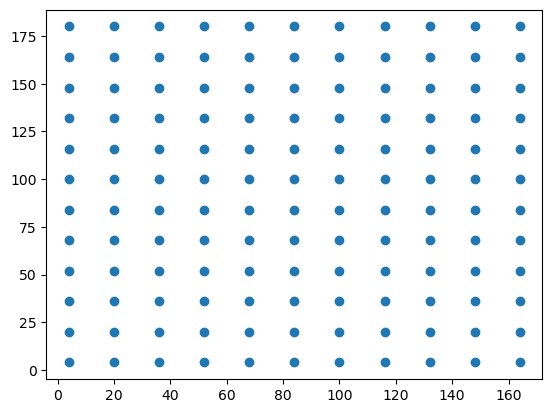

In [70]:
# RECEIVERS
rz = 40*dz*np.ones(nr)

dr_xyz = 4*dx

grid_y_locs = np.arange(dy, (dy*ny)-dy, dr_xyz)
grid_x_locs = np.arange(dx, (dx*nx)-dx, dr_xyz)

rx, ry, rz = np.meshgrid(grid_rx,
                         grid_ry,
                         dz) 


recs = np.vstack((rx.flatten(), ry.flatten(), rz.flatten()))
nr = recs.shape[1]
plt.scatter(rx,ry)
print(recs.shape)

# COLLECT NECESSARY INFORMATION FOR SOURCE LOCATIONS

- Traveltime Tables
- Take-off Angles
- Receiver Angles

## COMPUTE TRAVELTIME - NR,NX,NY,NZ

In [67]:
# TRAVEL TIME TABLE
trav = Kirchhoff._traveltime_table(z, 
                                   x, 
                                   y=y, 
                                   recs=recs, 
                                   srcs=recs[:,:1], 
                                   vel=vel, 
                                   mode='eikonal')[1]

In [74]:
TTT_full = trav.reshape(nx,ny,nz,nr).transpose([3,0,1,2])

In [186]:
np.mean(TTT_full)

0.18519802789788006

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='y samples', ylabel='x samples'>,
  <Axes: xlabel='z samples'>,
  <Axes: ylabel='z samples'>))

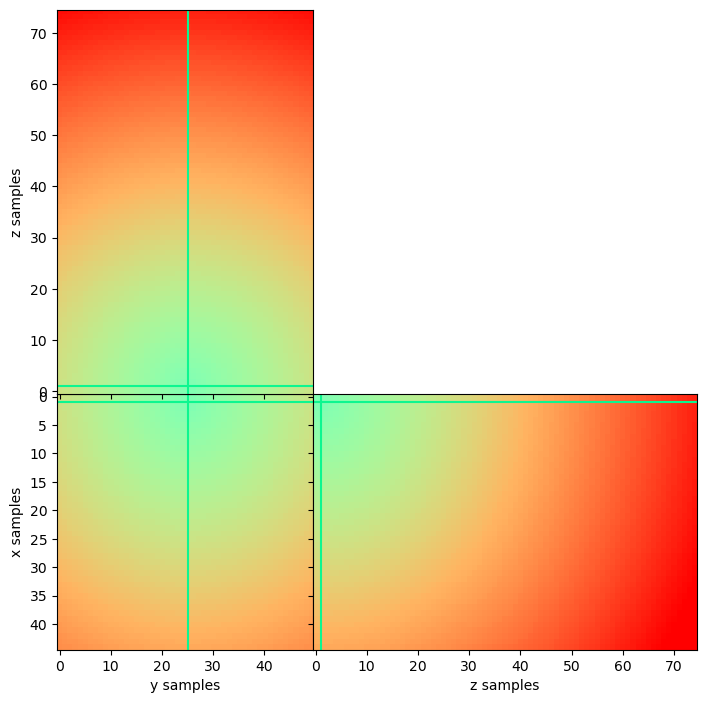

In [123]:
explode_volume(TTT_full[nr//2], 
               t=int(recs[0,nr//2]/dx), 
               x=int(recs[1,nr//2]/dy), 
               y=int(recs[2,nr//2]/dz),
               cmap='rainbow',
                   figsize=(8, 8), clipval=None, p=98,
                   tlim=None, xlim=None, ylim=None,
                   tcrop=None, xcrop=None, ycrop=None,
                   labels=('[x]', '[y]', '[z]'),
                   tlabel='x', xlabel='y', ylabel='z',
                   ratio=None, linespec=None, interp=None, title='',
                   filename=None, save_opts=None)

## TAKEOFF ANGLES

### Table of r (radial distance)

In [147]:
# ANALYTICL R - ASSUMES HOMO
s_locs_x, s_locs_y, s_locs_z = np.meshgrid(x,y,z,indexing='ij')
RDT_full = np.zeros_like(TTT_full)
for i,r in enumerate(recs.T):
    RDT_full[i] = np.sqrt((s_locs_x - r[0])**2 + (s_locs_y - r[1])**2 + (s_locs_z - r[2])**2 )

    # For angle calculation make magnitude tables in x, y, z

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='y samples', ylabel='x samples'>,
  <Axes: xlabel='z samples'>,
  <Axes: ylabel='z samples'>))

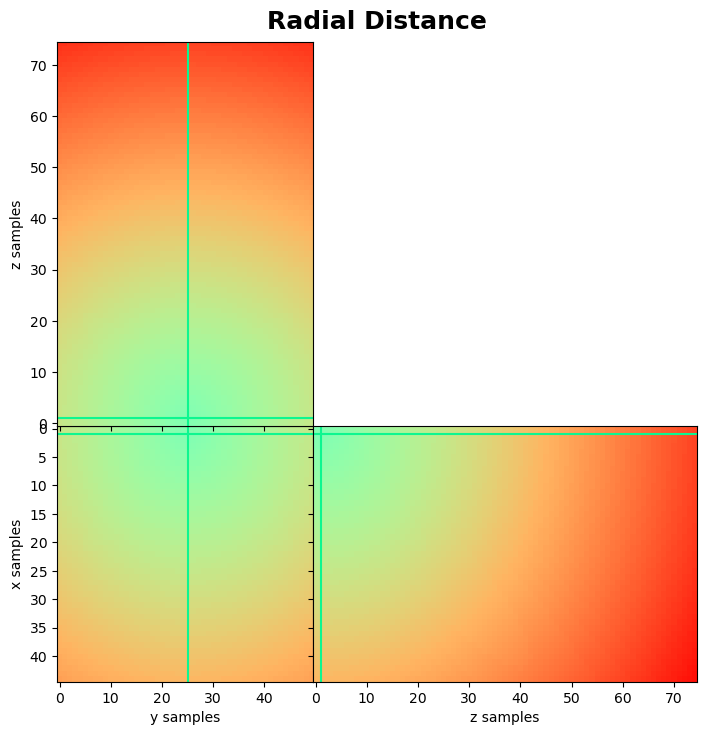

In [148]:
# plt.imshow(RDT_full[0,1].T)
explode_volume(RDT_full[nr//2], 
               t=int(recs[0,nr//2]/dx), 
               x=int(recs[1,nr//2]/dy), 
               y=int(recs[2,nr//2]/dz),
               cmap='rainbow',
               figsize=(8, 8), 
               p=100,
               labels=('[x]', '[y]', '[z]'),
               tlabel='x', xlabel='y', ylabel='z',
               ratio=None, linespec=None, interp=None, title='Radial Distance',
               filename=None, save_opts=None)

### Non-Homo assumption

In [165]:
# Take gradients in x, y and z (equivalent to Ax, Ay, Az in equations from https://engineeringstatics.org/coordinates-3d.html)
dTdx_full, dTdy_full, dTdz_full =  np.gradient(TTT_full, dx, dy, dz, axis=[1,2,3], )
RDT_full = np.sqrt(dTdx_full**2 + dTdy_full**2 + dTdz_full**2 )

# # Compute the angle 
# theta_takeoff_rads = np.arctan(dTdx_full/dTdz_full)
# theta_takeoff_degs = np.rad2deg(theta_takeoff_rads)

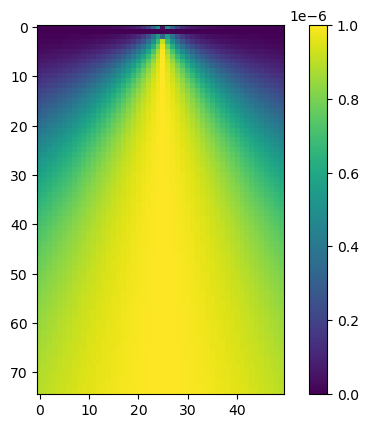

In [195]:
rec_index = nr//2 + 5
recloc = recs[:,rec_index]

plt.imshow((dTdz_full[rec_index, recloc[0]//dx]**2).T)
plt.colorbar()

In [196]:
RDT_full.std()

4.33338045272802e-06

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='y samples', ylabel='x samples'>,
  <Axes: xlabel='z samples'>,
  <Axes: ylabel='z samples'>))

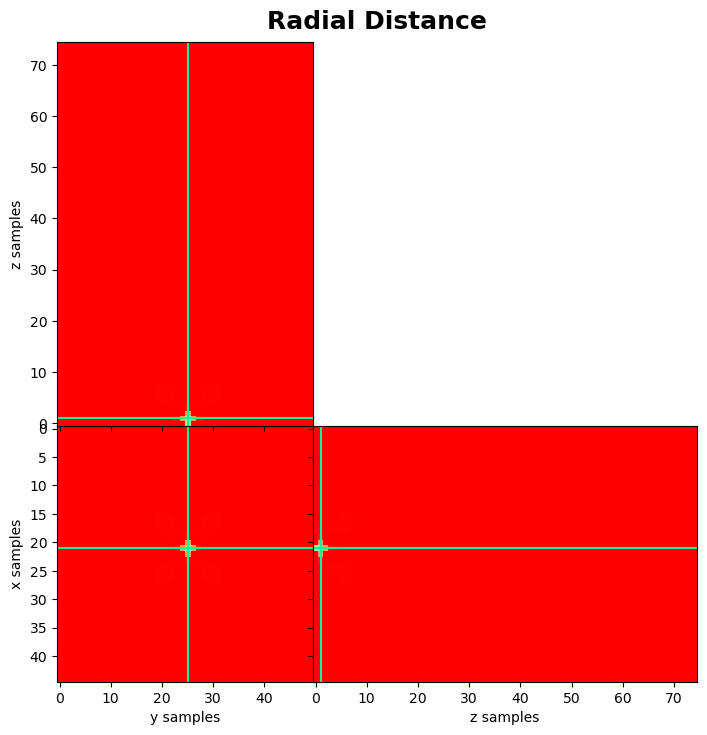

In [197]:
# plt.imshow(RDT_full[0,1].T)
explode_volume(RDT_full[rec_index], 
               t=int(recs[0,rec_index]/dx), 
               x=int(recs[1,rec_index]/dy), 
               y=int(recs[2,rec_index]/dz),
               cmap='rainbow',
               figsize=(8, 8), 
               p=90,
               labels=('[x]', '[y]', '[z]'),
               tlabel='x', xlabel='y', ylabel='z',
               ratio=None, linespec=None, interp=None, title='Gradient Distance',
               filename=None, save_opts=None)

### Polar Angle: $\phi = cos^{-1}(A_z/A)$

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='y samples', ylabel='x samples'>,
  <Axes: xlabel='z samples'>,
  <Axes: ylabel='z samples'>))

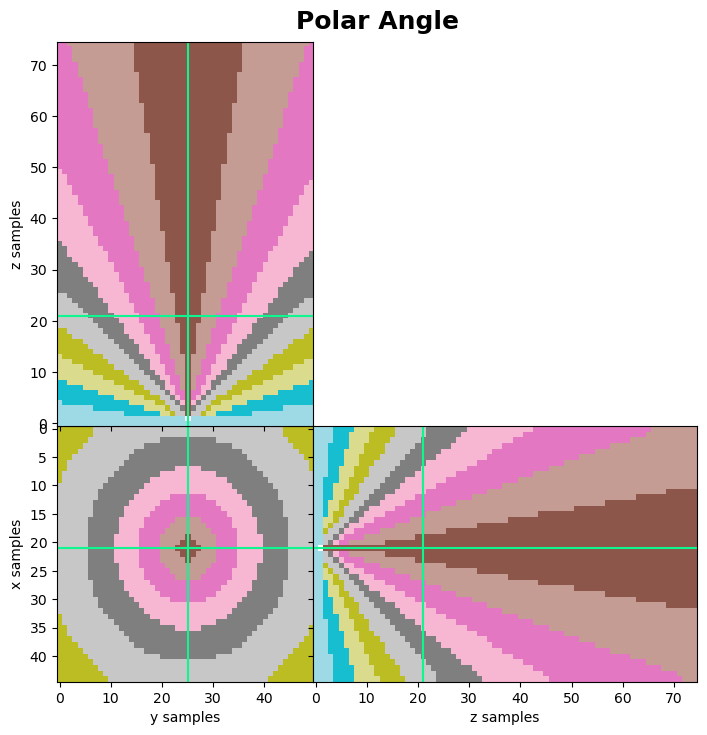

In [222]:
TO_phi_rads = np.arccos(dTdz_full/RDT_full)
TO_phi_degs = np.rad2deg(TO_phi_rads)
phi_rads.shape

# plt.imshow(RDT_full[0,1].T)
explode_volume(TO_phi_degs[rec_index], 
               t=int(recs[0,rec_index]/dx),
               x=int(recs[1,rec_index]/dy), 
               y=int(recs[2,rec_index]/dz)+20,
               cmap='tab20',
               figsize=(8, 8), 
               clipval=[-90,90],
               labels=('[x]', '[y]', '[z]'),
               tlabel='x', xlabel='y', ylabel='z',
               ratio=None, linespec=None, interp=None, title='Polar Angle',
               filename=None, save_opts=None)

### Azimuthal Angle: $\theta = \sin^{-1}(A_y/(A\sin\phi) $

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='y samples', ylabel='x samples'>,
  <Axes: xlabel='z samples'>,
  <Axes: ylabel='z samples'>))

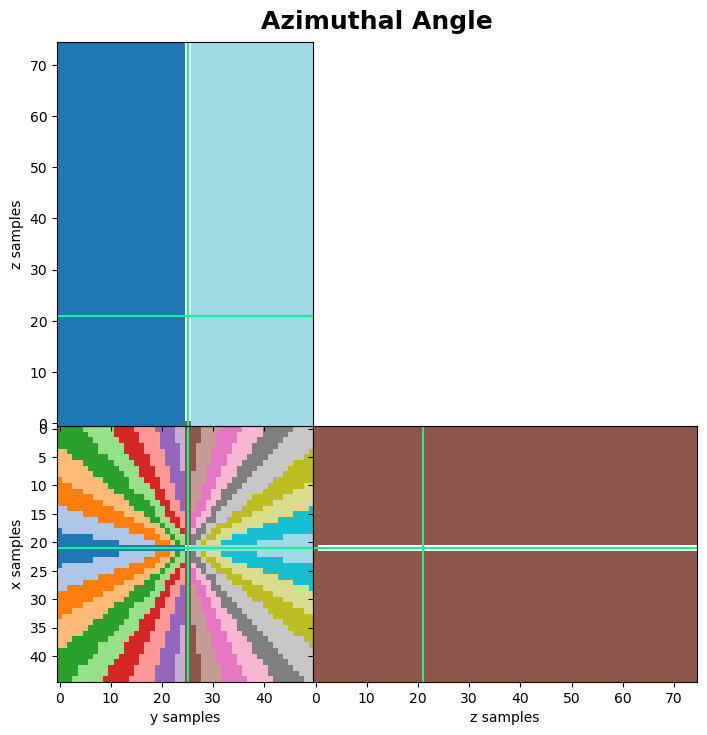

In [221]:
TO_theta_rads = dTdy_full / (RDT_full*np.sin(TO_phi_rads))
TO_theta_rads[TO_theta_rads>1] = 1
TO_theta_rads[TO_theta_rads<-1] = -1
TO_theta_rads = np.arcsin(TO_theta_rads)
TO_theta_degs = np.rad2deg(TO_theta_rads)

# plt.imshow(RDT_full[0,1].T)
explode_volume(TO_theta_degs[rec_index], 
               t=int(recs[0,rec_index]/dx),
               x=int(recs[1,rec_index]/dy), 
               y=int(recs[2,rec_index]/dz)+20,
               cmap='tab20',
               figsize=(8, 8), 
               clipval=[-90,90],
               labels=('[x]', '[y]', '[z]'),
               tlabel='x', xlabel='y', ylabel='z',
               ratio=None, linespec=None, interp=None, title='Azimuthal Angle',
               filename=None, save_opts=None)